## Q5: Use the available variables to construct a model that predicts delays.

### Importing datasets and libraries

In [3]:
import warnings
warnings.filterwarnings('ignore') # This ignores warnings that appear with ouputs

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import plot_roc_curve

In [5]:
fullset = pd.read_csv('../datasets/fullset cleaned.csv')
planes = pd.read_csv('../datasets/plane data cleaned.csv')

### Data Wrangling

In [6]:
# Subsetting and creating columns with dummy variable to represent departure delay if delay length > 15, and 0 otherwise

model1 = fullset[['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime', 'TailNum', 'DepDelay', 'Origin', 'Dest']]
model2 = planes[['tailnum', 'year']]

model1['DepDelayed'] = np.where(model1["DepDelay"] > 15, 1, 0)

# Merging with plane data to get the corresponding years of manufacture

model = pd.merge(model1, model2, left_on='TailNum', right_on='tailnum')

In [7]:
model.year.value_counts() #Checking for consistency in values

2001    1104367
2002     889007
2000     873931
2003     842526
1999     839318
2004     735168
1998     676997
2005     593303
1988     386807
1996     386620
1991     368946
1997     356769
None     351276
1992     339206
1990     338796
1987     334172
2006     320645
1994     314060
1995     307708
1989     290669
1985     256048
1993     255093
1986     229929
2007      89061
1984      66851
1968      65140
1983      43192
1967      36487
1969      34318
1979      29244
1978      25539
1975      24809
1976      24764
1980      20538
1977      13625
1982      10956
0         10422
1973       7902
1970       5812
1959       5010
1966       3205
1963       3173
1974       3151
1962       2818
1964       2793
1971       2784
1965       2550
1957       1793
1956        556
1972        531
Name: year, dtype: int64

In [13]:
# Removing inconsistent values

model = model[(model['year'] != 'None') & 
                              (model['year'] != '0')]

In [14]:
# Sampling out 2 million rows for building predictive model
# (due to computational power limits, the model cannot be built using the entire dataset)

model = model.sample(n=2000000)

### Setting up Pipeline

In [15]:
#Selecting the features to be used for training the model

features = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime', 'year', 'Origin', 'Dest']
numerical_features = ['CRSDepTime'] 
categorical_features = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Origin', 'Dest', 'year'] 

# Year = 2006/2007, year = year of manufacture

In [16]:
# Setting up variables for feature transformation

X = model[features].copy()

numerical_transformer = Pipeline(steps=[ ('imputer', SimpleImputer()), ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[ ('imputer', SimpleImputer()), ('onehot', OneHotEncoder(handle_unknown='ignore'))])

data_transformer = ColumnTransformer(transformers=[('numerical', numerical_transformer, numerical_features),
                                                   ('categorical', categorical_transformer, categorical_features)])

In [17]:
# Splitting the dataset into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, model.DepDelayed, test_size=0.5, random_state=1)

# test size indicates that 50% of the data will be taken as test set, the random state=1 ensures that the 
# dataset is split in the same way each time the code is run to allow the results to be replicated

### Building a Logistic Regression model

In [18]:
logreg_pipe = Pipeline(steps=[('data_transformer', data_transformer), ('logreg_pipe', LogisticRegression(max_iter=10000))])

In [19]:
# Creating parameter grid to perform grid search for hyperparameter tuning to optimize model performance

param_grid = {
'data_transformer__numerical__imputer__strategy': ['mean', 'median'],
'data_transformer__categorical__imputer__strategy': ['constant','most_frequent']
}

logreg_grid = GridSearchCV(logreg_pipe, param_grid=param_grid) # Performing grid search
logreg_grid.fit(X_train, y_train); # Fitting train data to model

## Evaluating Model

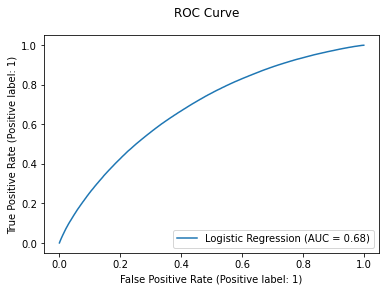

In [33]:
# Plotting ROC Curve and calculating AUC score

ax = plt.gca()
roc = plot_roc_curve(logreg_grid, X_test, y_test, ax=ax, name='Logistic Regression') 
roc.figure_.suptitle("ROC Curve")

plt.savefig('ROC Curve.png')